In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [112]:
#Looking at Building class category - 01 ONE FAMILY DWELLINGS has 5061 rows
df.BUILDING_CLASS_CATEGORY.value_counts()
#Subsetting data to one family dwellings
df = df.query('BUILDING_CLASS_CATEGORY == "01 ONE FAMILY DWELLINGS"')
df.shape

(5061, 21)

In [113]:
# Getting the price statistics of the sub data
df.SALE_PRICE.describe()
#Subsetting the data to sale price between 100 thousand and two million
df = df.query('SALE_PRICE>100000 & SALE_PRICE<2000000')
print(df.shape)
df.SALE_PRICE.describe()

(3151, 21)


count    3.151000e+03
mean     6.285601e+05
std      2.929904e+05
min      1.040000e+05
25%      4.475000e+05
50%      5.680000e+05
75%      7.600000e+05
max      1.955000e+06
Name: SALE_PRICE, dtype: float64

In [264]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
#changing sale date to date time format
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'],infer_datetime_format=True)

In [7]:
df.SALE_DATE.dt.month.value_counts()

1    947
3    799
2    761
4    644
Name: SALE_DATE, dtype: int64

In [115]:
#Splitting data into train and test
train = df[df.SALE_DATE.dt.month != 4].copy()
test = df[df.SALE_DATE.dt.month == 4].copy()
train.shape,test.shape

((2507, 21), (644, 21))

In [62]:
train.select_dtypes('number').columns

Index(['BLOCK', 'LOT', 'EASE-MENT', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'land_per_gross',
       'land_and_gross'],
      dtype='object')

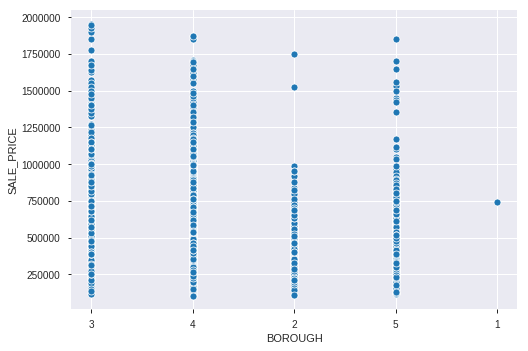

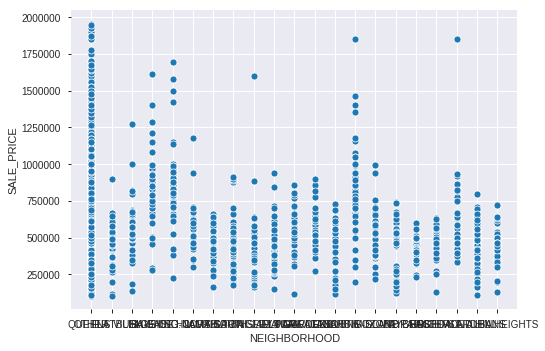

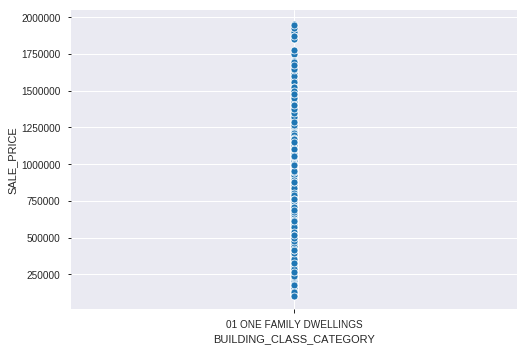

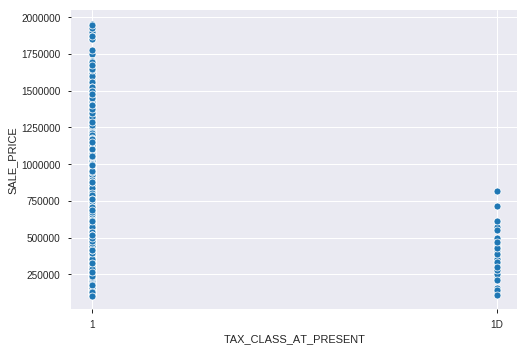

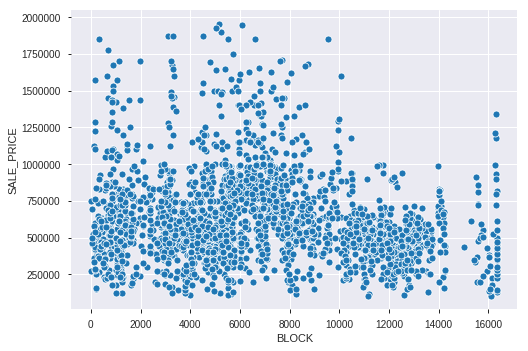

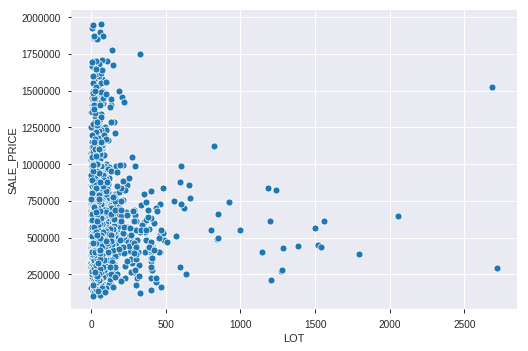

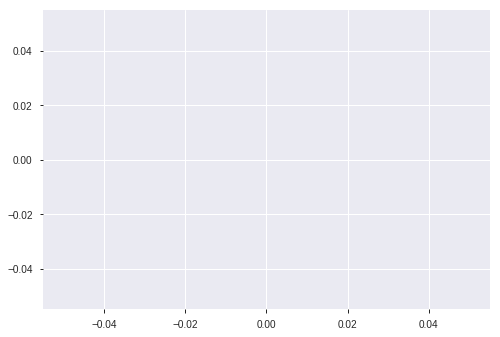

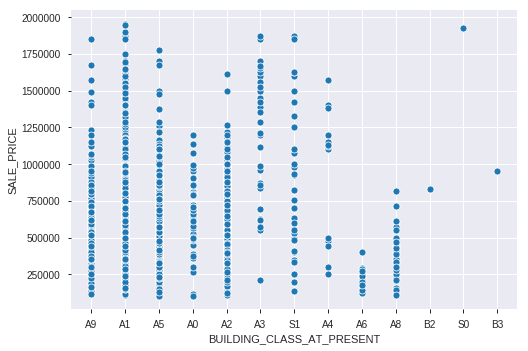

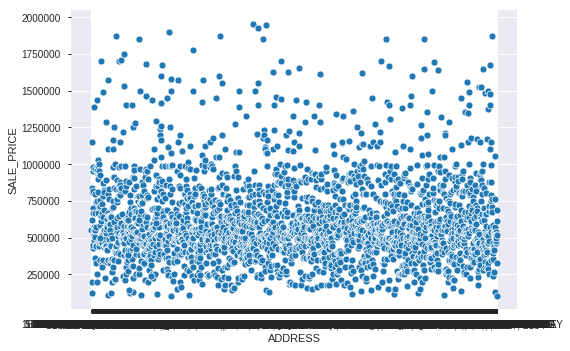

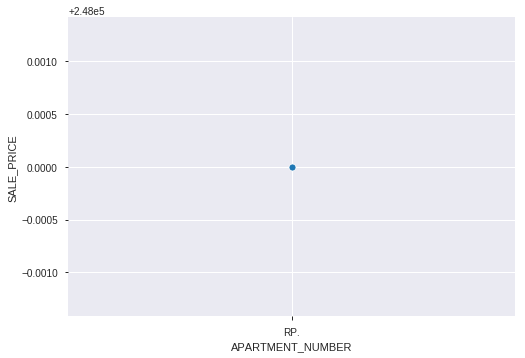

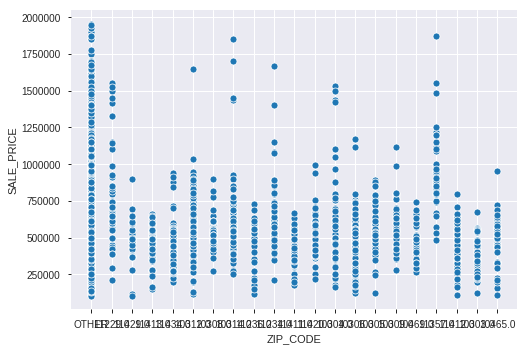

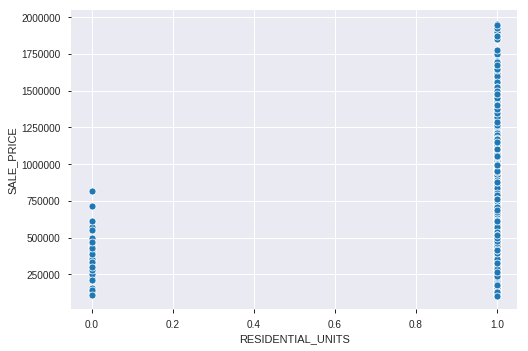

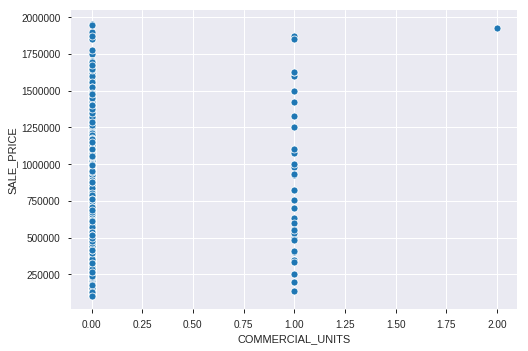

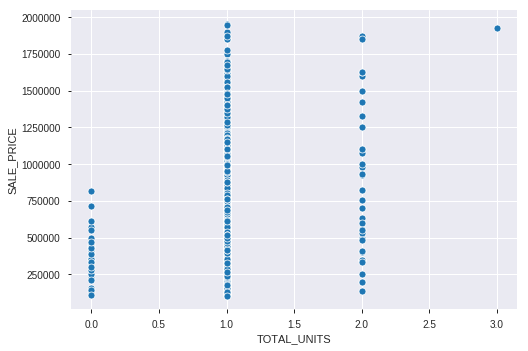

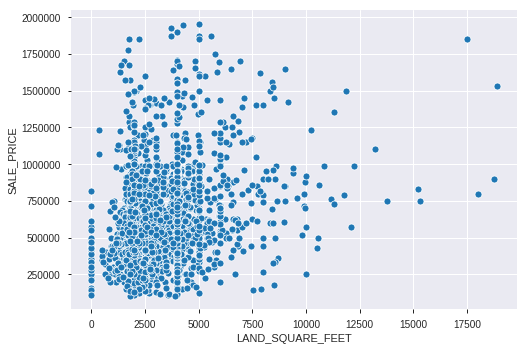

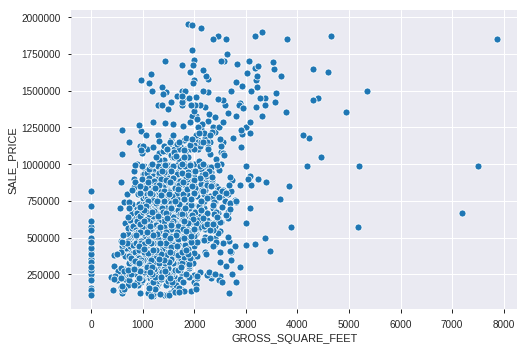

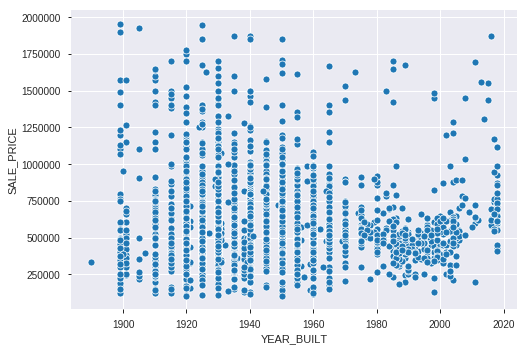

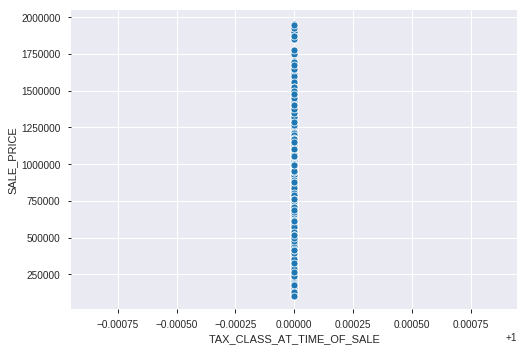

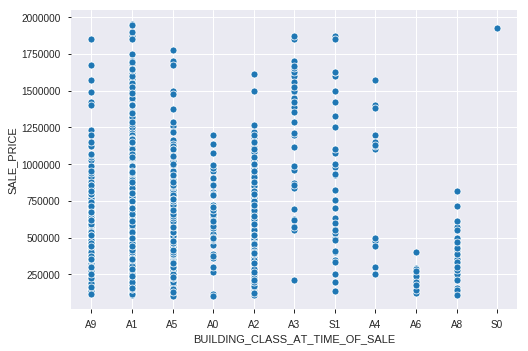

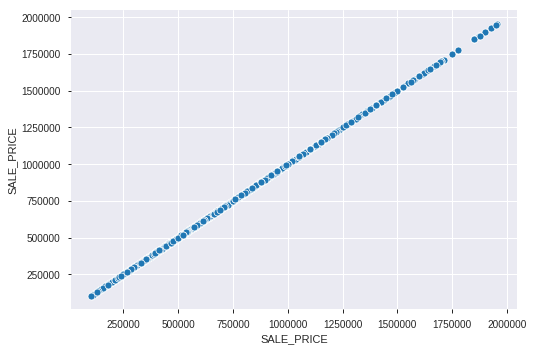

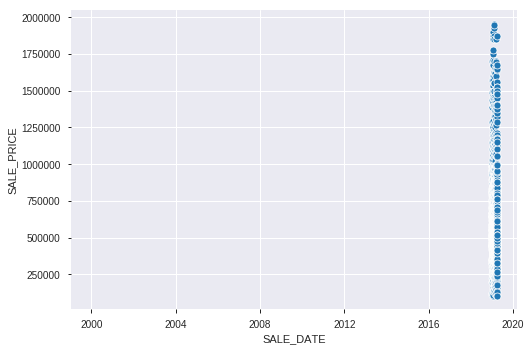

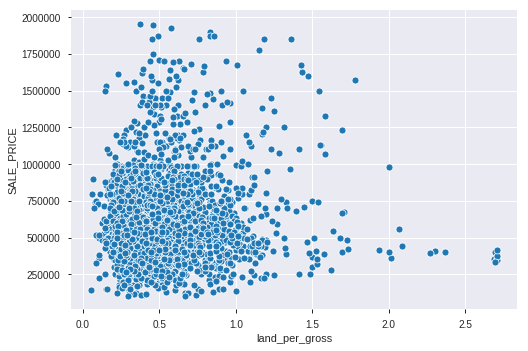

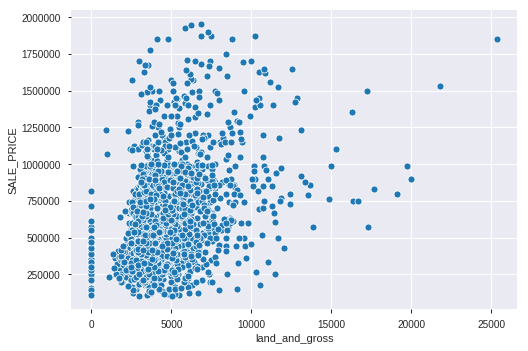

In [63]:
#Using visualisation to understand features
import matplotlib.pyplot as plt
import seaborn as sns
for col in train:
  ax = sns.scatterplot(x=col,y='SALE_PRICE',data=train)
  plt.show()
  

In [11]:
#checking for GROSS_SQUARE_FEET is zero
train.query('GROSS_SQUARE_FEET==0').describe()

,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,31.000000,31.000000,31.000000,0.0,31.000000,31.0,31.0,31.0,31.0,31.0,31.000000,31.0,31.0000
mean,3.354839,12849.516129,222.354839,NaN,11299.580645,0.0,0.0,0.0,0.0,0.0,1932.935484,1.0,392900.0000
std,0.950382,5153.738474,173.539918,NaN,585.435267,0.0,0.0,0.0,0.0,0.0,7.637345,0.0,168174.8039
min,2.000000,5455.000000,1.000000,NaN,10465.000000,0.0,0.0,0.0,0.0,0.0,1921.000000,1.0,110000.0000
25%,2.000000,5510.500000,50.000000,NaN,10465.000000,0.0,0.0,0.0,0.0,0.0,1923.000000,1.0,288500.0000
50%,4.000000,16350.000000,300.000000,NaN,11697.000000,0.0,0.0,0.0,0.0,0.0,1938.000000,1.0,390000.0000
75%,4.000000,16350.000000,400.000000,NaN,11697.000000,0.0,0.0,0.0,0.0,0.0,1938.000000,1.0,462500.0000
max,4.000000,16350.000000,400.000000,NaN,11697.000000,0.0,0.0,0.0,0.0,0.0,1938.000000,1.0,820000.0000


In [12]:
train.query('GROSS_SQUARE_FEET==0').describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,31,31,31,31,31,0.0,31,31
unique,2,1,1,1,31,0.0,1,22
top,BREEZY POINT,01 ONE FAMILY DWELLINGS,1D,A8,"292 HILLSIDE AVENUE, 2543",NaN,A8,2019-01-16 00:00:00
freq,21,31,31,31,1,NaN,31,3
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-26 00:00:00


In [13]:
# #removing gross square feet zero from the data
# train = train.query('GROSS_SQUARE_FEET!=0')
# test = test.query('GROSS_SQUARE_FEET!=0')
# train.shape, test.shape

((2476, 21), (635, 21))

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

#Zip code as a categorical feature and reducing the cardinal feature
train['ZIP_CODE'] = train['ZIP_CODE'].astype(str)
test['ZIP_CODE'] = test['ZIP_CODE'].astype(str)

# Get a list of the top 10 neighborhoods
top10zipcodes = train['ZIP_CODE'].value_counts()[:20].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['ZIP_CODE'].isin(top10zipcodes), 'ZIP_CODE'] = 'OTHER'
test.loc[~test['ZIP_CODE'].isin(top10zipcodes), 'ZIP_CODE'] = 'OTHER'


# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:20].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'


In [0]:
#Dropping columns Address it has null values and apartment number and TAX_CLASS_AT_TIME_OF_SALE as they have single value
# train = train.drop(columns=['EASE-MENT','ADDRESS','APARTMENT_NUMBER','TAX_CLASS_AT_TIME_OF_SALE'])
# test = test.drop(columns=['EASE-MENT','ADDRESS','APARTMENT_NUMBER','TAX_CLASS_AT_TIME_OF_SALE'])

In [0]:
#Converting land square feet to number
train['LAND_SQUARE_FEET'] = train['LAND_SQUARE_FEET'].str.replace(',','').str.replace(' ','').astype(int)
test['LAND_SQUARE_FEET'] = test['LAND_SQUARE_FEET'].str.replace(',','').str.replace(' ','').astype(int)

In [0]:
#Binning Year Built as category value
year_bins = [year for year in range(int(train.YEAR_BUILT.min())-1,int(train.YEAR_BUILT.max())+11,10)]
labels = [str(year)+'year' for year in range(int(train.YEAR_BUILT.min())-1,int(train.YEAR_BUILT.max()),10)]
train['YEAR_BIN'] = pd.cut(train['YEAR_BUILT'],bins=year_bins,labels=labels)
test['YEAR_BIN'] = pd.cut(test['YEAR_BUILT'],bins=year_bins,labels=labels)

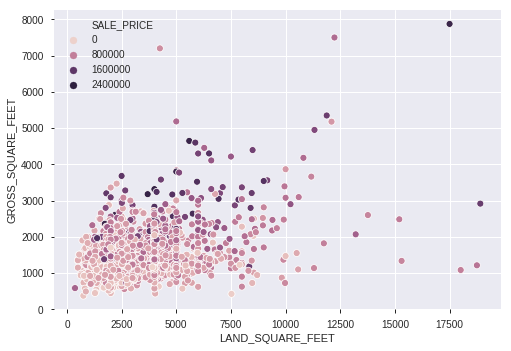

In [31]:
sns.scatterplot(x=train['LAND_SQUARE_FEET'],y=train['GROSS_SQUARE_FEET'],hue=train['SALE_PRICE']);

In [0]:
#adding a new features
import numpy as np
train['land_per_gross']=(train['GROSS_SQUARE_FEET']/train['LAND_SQUARE_FEET']).replace(np.Inf,9999).fillna(0)
train['land_and_gross']=train['GROSS_SQUARE_FEET']+train['LAND_SQUARE_FEET']
test['land_per_gross']=(test['GROSS_SQUARE_FEET']/test['LAND_SQUARE_FEET']).replace(np.Inf,9999).fillna(0)
test['land_and_gross']=test['GROSS_SQUARE_FEET']+test['LAND_SQUARE_FEET']

In [57]:
for col in train.select_dtypes(include='number'):
  print(col,train[col].nunique())

BLOCK 2060
LOT 304
EASE-MENT 0
RESIDENTIAL_UNITS 2
COMMERCIAL_UNITS 3
TOTAL_UNITS 4
LAND_SQUARE_FEET 887
GROSS_SQUARE_FEET 922
YEAR_BUILT 86
TAX_CLASS_AT_TIME_OF_SALE 1
SALE_PRICE 880
land_per_gross 2025
land_and_gross 1699


In [122]:
for col in train.select_dtypes(exclude='number'):
  print(col,train[col].nunique())

BOROUGH 5
NEIGHBORHOOD 21
BUILDING_CLASS_CATEGORY 1
TAX_CLASS_AT_PRESENT 2
BUILDING_CLASS_AT_PRESENT 13
ADDRESS 2497
APARTMENT_NUMBER 1
ZIP_CODE 21
BUILDING_CLASS_AT_TIME_OF_SALE 11
SALE_DATE 68
YEAR_BIN 13


In [0]:
target = 'SALE_PRICE'
cat_columns = ['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT',
       'ZIP_CODE', 'BUILDING_CLASS_AT_TIME_OF_SALE','YEAR_BIN']
numerical_columns = list(train.select_dtypes(include='number').columns.drop([target,'EASE-MENT','TAX_CLASS_AT_TIME_OF_SALE','YEAR_BUILT']))
features = cat_columns+numerical_columns

In [124]:
features

['BOROUGH',
 'NEIGHBORHOOD',
 'TAX_CLASS_AT_PRESENT',
 'BUILDING_CLASS_AT_PRESENT',
 'ZIP_CODE',
 'BUILDING_CLASS_AT_TIME_OF_SALE',
 'YEAR_BIN',
 'BLOCK',
 'LOT',
 'RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'LAND_SQUARE_FEET',
 'GROSS_SQUARE_FEET',
 'land_per_gross',
 'land_and_gross']

In [125]:
train[features].isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
TAX_CLASS_AT_PRESENT              0
BUILDING_CLASS_AT_PRESENT         0
ZIP_CODE                          0
BUILDING_CLASS_AT_TIME_OF_SALE    0
YEAR_BIN                          0
BLOCK                             0
LOT                               0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
land_per_gross                    0
land_and_gross                    0
dtype: int64

In [91]:
for col in features:
  print(col,test[col].nunique())

BOROUGH 5
NEIGHBORHOOD 21
TAX_CLASS_AT_PRESENT 2
BUILDING_CLASS_AT_PRESENT 11
ZIP_CODE 21
BUILDING_CLASS_AT_TIME_OF_SALE 10
BLOCK 610
LOT 172
RESIDENTIAL_UNITS 3
COMMERCIAL_UNITS 2
TOTAL_UNITS 3
LAND_SQUARE_FEET 294
GROSS_SQUARE_FEET 401
YEAR_BUILT 51
land_per_gross 1
land_and_gross 557


In [0]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

y_train = train[target]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(train[features])
X_test_encoded = encoder.transform(test[features])

scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train_encoded)
# X_test_scaled = scaler.transform(X_test_encoded)
X_train_scaled = X_train_encoded
X_test_scaled = X_test_encoded

In [127]:
X_train_encoded.shape,X_test_encoded.shape,X_train_scaled.shape,X_test_scaled.shape

((2507, 95), (644, 95), (2507, 95), (644, 95))

In [128]:
for k in range(1,(X_train_scaled.shape[1]+1)):

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selector =  selector.fit_transform(X_train_scaled,y_train)
  X_test_selector = selector.transform(X_test_scaled)
  model = LinearRegression()
  model.fit(X_train_selector,y_train)
  train_predict = model.predict(X_train_selector)
  test_predict = model.predict(X_test_selector)
  print(f'{k} Test:{mean_absolute_error(y_test,test_predict)}')

1 Test:183640.5858012459
2 Test:179554.76843033519
3 Test:179554.7684303352
4 Test:173576.46421645748
5 Test:171943.1889741962
6 Test:172108.28266369915
7 Test:170326.7154160005
8 Test:169686.18862756412
9 Test:168755.33255273188
10 Test:165876.3343125043
11 Test:161959.1202595544
12 Test:161824.90983592923
13 Test:155065.77002714333
14 Test:154279.71902318404
15 Test:155711.5346060629
16 Test:153940.00533337344
17 Test:153913.71063392615
18 Test:153916.56860268215
19 Test:153757.0579776756
20 Test:153724.3774964557
21 Test:155892.28473416108
22 Test:155876.08987827683
23 Test:155722.43136712688
24 Test:155630.14012286247
25 Test:155630.14012285337
26 Test:155179.30391843832
27 Test:155611.02680208822
28 Test:154213.76732646825
29 Test:173898.75483842022
30 Test:154330.25327922232
31 Test:154330.07984049225
32 Test:154330.07984049342
33 Test:154365.57496937437
34 Test:154330.07984047383
35 Test:608175816.5606774
36 Test:153996.2378892868
37 Test:153938.57427955407
38 Test:153901.566291

In [155]:
#Organising the code
import pandas as pd
import pandas_profiling
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import RidgeCV


# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')
# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)
#Looking at Building class category - 01 ONE FAMILY DWELLINGS has 5061 rows
#Subsetting data to one family dwellings
df = df.query('BUILDING_CLASS_CATEGORY == "01 ONE FAMILY DWELLINGS"')
#Subsetting the data to sale price between 100 thousand and two million
df = df.query('SALE_PRICE>100000 & SALE_PRICE<2000000')
#changing sale date to date time format
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'],infer_datetime_format=True)
#Splitting data into train and test
train = df[df.SALE_DATE.dt.month != 4].copy()
test = df[df.SALE_DATE.dt.month == 4].copy()

#Converting land square feet to number
train['LAND_SQUARE_FEET'] = train['LAND_SQUARE_FEET'].str.replace(',','').str.replace(' ','').astype(int)
test['LAND_SQUARE_FEET'] = test['LAND_SQUARE_FEET'].str.replace(',','').str.replace(' ','').astype(int)

# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

TOPVALUE = 40
#Zip code as a categorical feature and reducing the cardinal feature
train['ZIP_CODE'] = train['ZIP_CODE'].astype(str)
test['ZIP_CODE'] = test['ZIP_CODE'].astype(str)

# Get a list of the top 10 neighborhoods
top10zipcodes = train['ZIP_CODE'].value_counts()[:TOPVALUE].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['ZIP_CODE'].isin(top10zipcodes), 'ZIP_CODE'] = 'OTHER'
test.loc[~test['ZIP_CODE'].isin(top10zipcodes), 'ZIP_CODE'] = 'OTHER'



# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:TOPVALUE].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

train['land_per_gross']=(train['GROSS_SQUARE_FEET']/train['LAND_SQUARE_FEET']).replace(np.Inf,9999).fillna(0)
train['land_and_gross']=train['GROSS_SQUARE_FEET']+train['LAND_SQUARE_FEET']
test['land_per_gross']=(test['GROSS_SQUARE_FEET']/test['LAND_SQUARE_FEET']).replace(np.Inf,9999).fillna(0)
test['land_and_gross']=test['GROSS_SQUARE_FEET']+test['LAND_SQUARE_FEET']

#Binning Year Built as category value
year_bins = [year for year in range(int(train.YEAR_BUILT.min())-1,int(train.YEAR_BUILT.max())+6,5)]
labels = [str(year)+'year' for year in range(int(train.YEAR_BUILT.min())-1,int(train.YEAR_BUILT.max()),5)]
train['YEAR_BIN'] = pd.cut(train['YEAR_BUILT'],bins=year_bins,labels=labels)
test['YEAR_BIN'] = pd.cut(test['YEAR_BUILT'],bins=year_bins,labels=labels)

#Dropping columns which have high cardinality or has only one value.
target = 'SALE_PRICE'
drop_columns = ['BUILDING_CLASS_CATEGORY','EASE-MENT','ADDRESS','APARTMENT_NUMBER','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE','SALE_DATE','SALE_PRICE']
features = train.columns.drop(drop_columns).to_list()

#Preparing data for encoding
y_train = (train[target])
y_test = (test[target])

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(train[features])
X_test_encoded = encoder.transform(test[features])

#Not scaling as the error blows up to e16

for k in range(1,(X_train_encoded.shape[1]+1)):

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selector =  selector.fit_transform(X_train_encoded,y_train)
  X_test_selector = selector.transform(X_test_encoded)
  model = RidgeCV()
  model.fit(X_train_selector,y_train)
  train_predict = (model.predict(X_train_selector))
  test_predict = (model.predict(X_test_selector))
  print(f'Features :{k} , MAE:{mean_absolute_error(y_test,test_predict):0.2f}')



Features :1 , MAE:183640.59
Features :2 , MAE:179554.77
Features :3 , MAE:179554.77
Features :4 , MAE:171343.23
Features :5 , MAE:171056.18
Features :6 , MAE:171099.71
Features :7 , MAE:169794.41
Features :8 , MAE:169219.55
Features :9 , MAE:168234.98
Features :10 , MAE:164693.05
Features :11 , MAE:159364.68
Features :12 , MAE:159345.95
Features :13 , MAE:153417.98
Features :14 , MAE:152371.89
Features :15 , MAE:151439.66
Features :16 , MAE:151131.60
Features :17 , MAE:151178.97
Features :18 , MAE:151948.75
Features :19 , MAE:149922.67
Features :20 , MAE:149924.10
Features :21 , MAE:149928.08
Features :22 , MAE:149554.47
Features :23 , MAE:149405.89
Features :24 , MAE:149400.65
Features :25 , MAE:151169.23
Features :26 , MAE:150988.11
Features :27 , MAE:150973.65
Features :28 , MAE:150830.69
Features :29 , MAE:150826.15
Features :30 , MAE:150812.73
Features :31 , MAE:149571.70
Features :32 , MAE:149461.45
Features :33 , MAE:150173.91
Features :34 , MAE:150269.30
Features :35 , MAE:1502

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) instead of Linear Regression, especially if your errors blow up! Watch [Aaron Gallant's 9 minute video on Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) to learn more.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.